IMPORTING NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

 Load dataset

In [ ]:
# Load dataset
df = pd.read_csv('/content/IMDB Dataset.csv')
df


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


 basic exploratory data analysis (EDA)

In [ ]:
df.shape

(50000, 2)

In [ ]:
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


<ipython-input-41-b27cad290e97>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


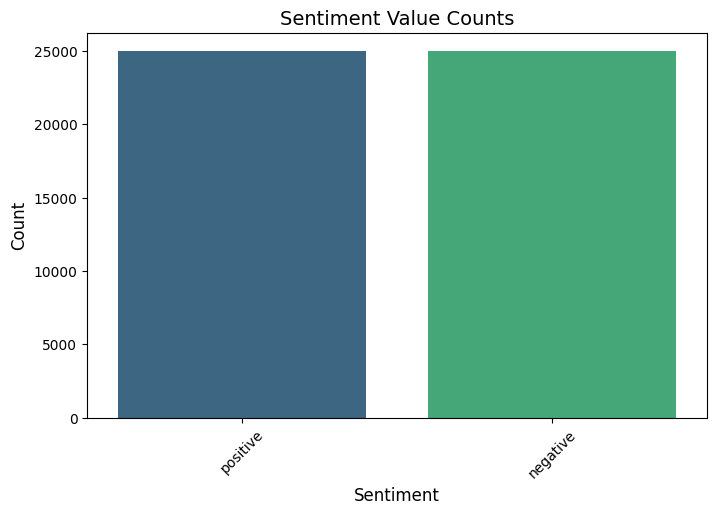

In [ ]:
sentiment_counts = df["sentiment"].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Adding labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Value Counts", fontsize=14)
plt.xticks(rotation=45)
plt.show()



In [ ]:
# basic exploratory data analysis (EDA)
print("Sample data:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution:")


Sample data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class distribution:


In [ ]:
print(df.describe())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


#ENCODING

In [ ]:
df.replace({"sentiment":{"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-44-a0261a54cbe9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment":{"positive": 1, "negative": 0}}, inplace=True)


In [ ]:
df["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


preprocessing

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove HTML tags, URLs, and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    return ' '.join(tokens)


In [ ]:
df['review'] = df['review'].apply(preprocess_text)
print(df[['review']].head())



                                              review
0  one reviewer mentioned watching oz episode you...
1  wonderful little production filming technique ...
2  thought wonderful way spend time hot summer we...
3  basically there family little boy jake think t...
4  petter matteis love time money visually stunni...


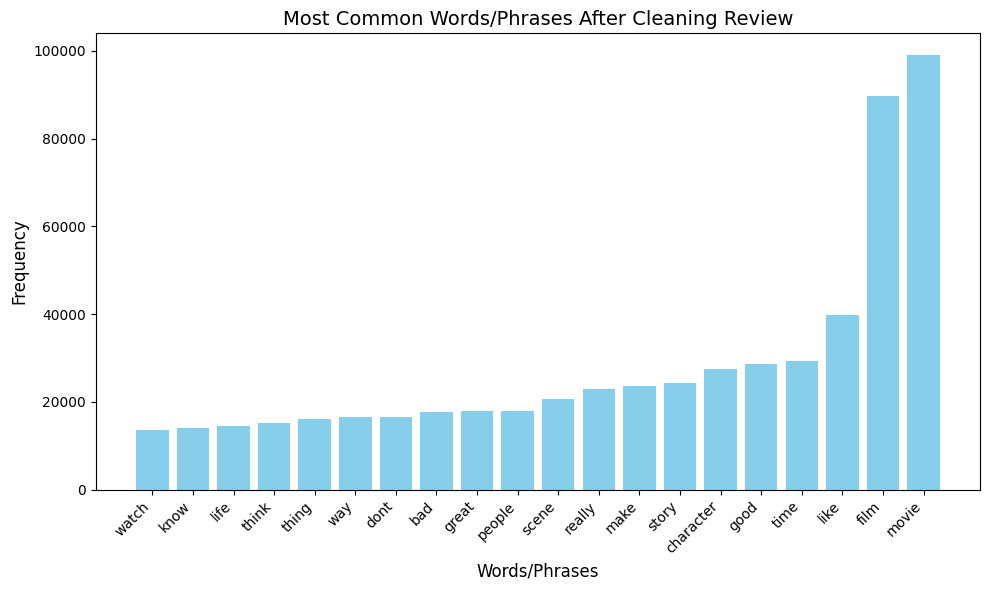

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df['review'])
words = vectorizer.get_feature_names_out()

word_counts_array = word_counts.toarray().sum(axis=0)  # Summing counts across all rows
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts_array})

# Sort by frequency in descending order
word_freq = word_freq.sort_values(by='count')

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(word_freq['word'], word_freq['count'], color='gray')
plt.xlabel('Words/Phrases', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Most Common Words/Phrases After Cleaning Review', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Split data into training and testing sets

In [ ]:
#  Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)


# Vectorize the text using TF-IDF

In [ ]:

#  Vectorize the text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()



In [ ]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#MACHINE LEARNING ALGORITHUMS:

In [ ]:
# Naive Bayes(ALG 1)
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)


#  Evaluate the model
y_pred = nb.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Model Evaluation:
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
def predict_sentiment_naive_bayes(review, vectorizer, model):
    vectorized_review = vectorizer.transform([review])
    prediction = model.predict(vectorized_review)
    senti = "positive" if prediction[0] == 1 else "negative"
    return senti


In [ ]:
new_review = "The movie was Amazing!"


# Predict sentiment
predicted_sentiment = predict_sentiment_naive_bayes(new_review, tfidf, nb)
print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: positive


In [ ]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression(ALG2)
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)


# Evaluate the model
y_pred = lr.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.88
Precision: 0.88
Recall: 0.90
F1 Score: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [ ]:
def predict_sentiment_logistic_regression(review, vectorizer, model):

    # Transform the review using the vectorizer
    vectorized_review = vectorizer.transform([review])

    # Predict sentiment using the Logistic Regression model
    prediction = model.predict(vectorized_review)

    # Map the prediction to sentiment labels
    senti = "positive" if prediction[0] == 1 else "negative"
    return senti


In [ ]:
new_review = "Awful movie"

# Predict sentiment using Logistic Regression
predicted_sentiment = predict_sentiment_logistic_regression(new_review, tfidf, lr)
print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: negative


#LOGESTIC REGRESSION PERFORM GOOD HERE

#DEEP LEARNING MODELS:

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense


lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.build(input_shape=(None, 100))

In [ ]:
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
lstm_model.fit(X_train_seq, y_train, batch_size=32, epochs=5, validation_data=(X_test_seq, y_test))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 251s 198ms/step - accuracy: 0.7884 - loss: 0.4335 - val_accuracy: 0.8648 - val_loss: 0.3132
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 199ms/step - accuracy: 0.8973 - loss: 0.2612 - val_accuracy: 0.8727 - val_loss: 0.2991
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 198ms/step - accuracy: 0.9203 - loss: 0.2089 - val_accuracy: 0.8697 - val_loss: 0.3096
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 265s 212ms/step - accuracy: 0.9344 - loss: 0.1735 - val_accuracy: 0.8717 - val_loss: 0.3404
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 311s 203ms/step - accuracy: 0.9477 - loss: 0.1397 - val_accuracy: 0.8685 - val_loss: 0.3872


In [ ]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
print("\nLSTM Performance:")
print("Accuracy:", lstm_accuracy)
print("Test Loss:", lstm_loss)


313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.8672 - loss: 0.3807

LSTM Performance:
Accuracy: 0.8684999942779541
Test Loss: 0.3871707320213318


In [ ]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = lstm_model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

#APPLYING RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense



In [ ]:
# Define constants
vocab_size = 10000  # Example vocabulary size; adjust based on your tokenizer
embedding_dim = 128  # Size of the embedding vector
max_len = 200  # Maximum length of sequences; adjust based on your dataset

# Define RNN Model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(units=128, activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN Model
rnn_history = rnn_model.fit(X_train_tfidf, y_train, epochs=3, batch_size=64, validation_data=(X_test_tfidf, y_test))

# Evaluate the RNN Model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_tfidf, y_test)
print(f"RNN Accuracy: {rnn_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
429/625 ━━━━━━━━━━━━━━━━━━━━ 21:20 7s/step - accuracy: 0.4984 - loss: 0.6966

#APPLYING CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Define constants
vocab_size = 10000  # Example vocabulary size; adjust based on your tokenizer
embedding_dim = 128  # Size of the embedding vector
max_len = 200  # Maximum length of sequences; adjust based on your dataset


# Define CNN Model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN Model
cnn_history = cnn_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_test_tfidf, y_test))

# Evaluate the CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_tfidf, y_test)
print(f"CNN Accuracy: {cnn_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.5044 - loss: 0.6950 - val_accuracy: 0.5039 - val_loss: 0.6932
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.5037 - loss: 0.6931 - val_accuracy: 0.4961 - val_loss: 0.6931
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.4998 - loss: 0.6932 - val_accuracy: 0.5039 - val_loss: 0.6931
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.5032 - loss: 0.6931 - val_accuracy: 0.4961 - val_loss: 0.6932
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4978 - loss: 0.6932
CNN Accuracy: 0.50


#COMPARISION BETWEEN LSTM RNN AND CNN

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    # Predict probabilities
    y_pred_probs = model.predict(X_test)
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate precision, recall, and F1 score
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(report)

# Evaluate LSTM Model
evaluate_model(lstm_model, X_test_tfidf, y_test, "LSTM")

# Evaluate RNN Model
evaluate_model(rnn_model, X_test_tfidf, y_test, "RNN")

# Evaluate CNN Model
evaluate_model(cnn_model, X_test_tfidf, y_test, "CNN")


313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step

--- LSTM Performance ---
Accuracy: 0.50
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      4961
    Positive       0.50      1.00      0.67      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.34     10000
weighted avg       0.25      0.50      0.34     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'rnn_model' is not defined

#TOPIC MODELING USING LDA

In [ ]:
# Import necessary libraries
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'processed_text' column contains the preprocessed text
# If not, preprocess the text (remove stopwords, punctuation, etc.)

#  Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_review'])

#  Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Specify number of topics
lda.fit(X)

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

#  Assign a topic to each document
df['topic'] = lda.transform(X).argmax(axis=1)
print(df[['review', 'topic']].head())  # Print first few rows with assigned topics


Topic 1:
movie br film character good like story great time really
Topic 2:
br film time character story like life make series episode
Topic 3:
film like kid movie girl good little old great time
Topic 4:
br film man war woman time story scene like movie
Topic 5:
br movie film like bad good really time make scene
                                              review  topic
0  One of the other reviewers has mentioned that ...      1
1  A wonderful little production. <br /><br />The...      1
2  I thought this was a wonderful way to spend ti...      0
3  Basically there's a family where a little boy ...      4
4  Petter Mattei's "Love in the Time of Money" is...      1


In [ ]:
df['topic']

KeyError: 'topic'

In [ ]:
import matplotlib.pyplot as plt

# Count the number of reviews for each topic
topic_counts = df['topic'].value_counts()

# Plot a bar chart for topic distribution
plt.bar(topic_counts.index, topic_counts.values, color='green')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.title('Topic Distribution Across Reviews')
plt.xticks(topic_counts.index, [f'Topic {i+1}' for i in topic_counts.index])
plt.show()


KeyError: 'topic'

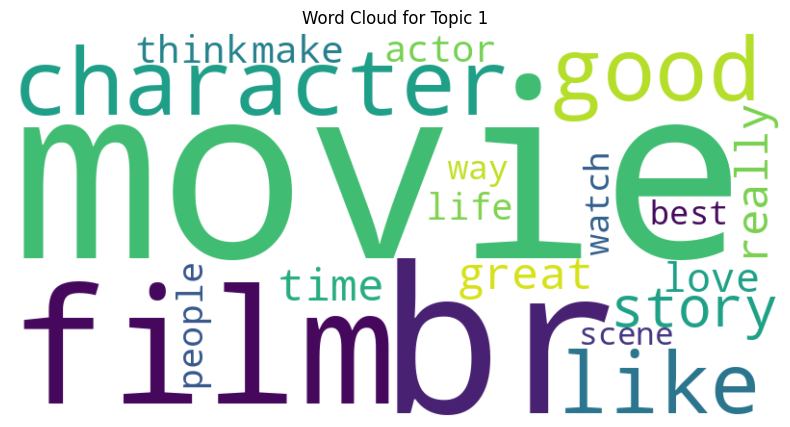

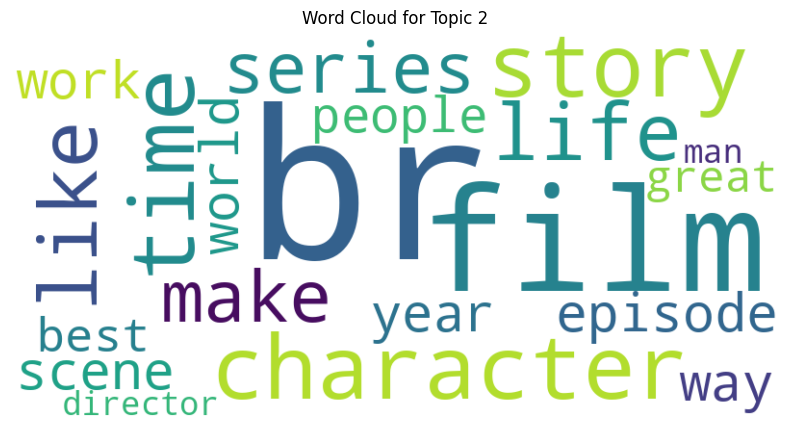

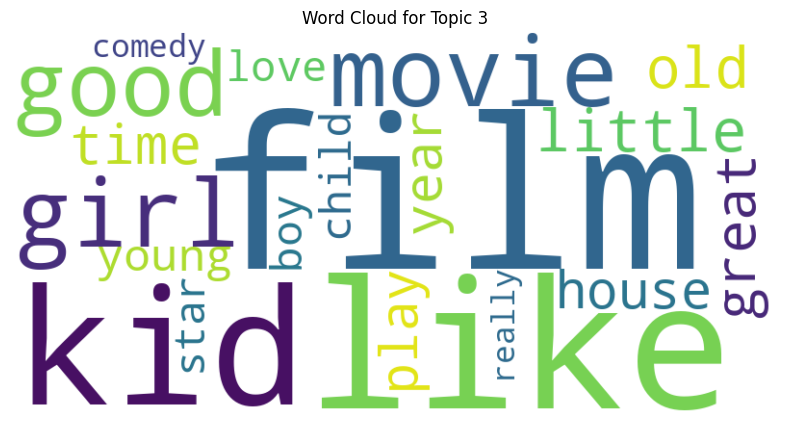

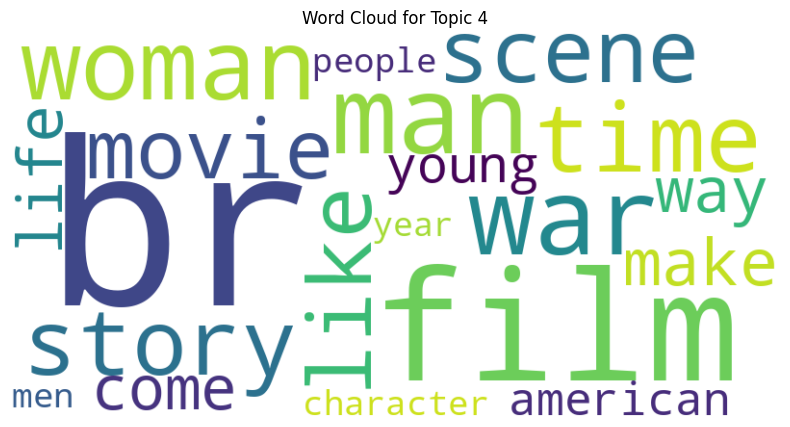

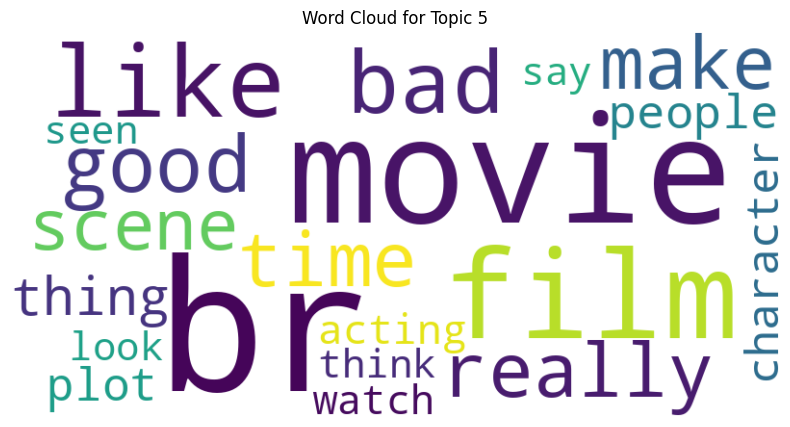

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda.components_):
    words = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-21:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.show()


In [ ]:
# Map topics to labels
topic_labels = {
    0: 'Acting',
    1: 'Music',
    2: 'Storyline',
    3: 'Cinematography',
    4: 'Direction'
}
df['topic_label'] = df['topic'].map(topic_labels)

# Print first few rows with topic labels
print(df[['review', 'topic_label']].head())


                                              review topic_label
0  One of the other reviewers has mentioned that ...       Music
1  A wonderful little production. <br /><br />The...       Music
2  I thought this was a wonderful way to spend ti...      Acting
3  Basically there's a family where a little boy ...   Direction
4  Petter Mattei's "Love in the Time of Money" is...       Music


In [ ]:
from sklearn.metrics import silhouette_score

# Evaluate coherence using silhouette score
topic_vectors = lda.transform(X)  # Using LDA transformed vectors
coherence = silhouette_score(topic_vectors, df['topic'])
print(f"Silhouette Coherence Score: {coherence}")


Silhouette Coherence Score: 0.42438367601160915


In [ ]:
import pandas as pd

genre_keywords = {
    "drama": ["realistic", "family", "character", "emotional", "struggle", "intense","life","relationship","conflict","tragic","oz","human relations"],
    "comedy": ["hilarious", "funny", "joke", "humor", "laugh", "lighthearted","comedy"],
    "romance": ["heartwarming", "affection", "romantic", "lovestory", "passion","titanic","jack","love story","relations","lighthearted"],
    "adventure": ["journey", "exotic", "wild", "quest", "exploration","adventure","hero"],
    "sci-fi": ["space", "robot", "technology","alien","scifi","planet","Star Trek","jedi"],
    "horror": ["creepy", "scary", "terrifying", "fear", "haunting", "blood","ghost","exorcism","supernatural","horror","vampire","zombie"],
    "mystery": ["secret", "clue", "detective", "investigation", "enigma", "whodunit"],
    "documentary": [ "biography", "history","quantum","documentary"],
    "animation": ["cartoon", "colorful", "drawn", "animated","anime","pixar","disney","sosuke"],
    "action": ["combat", "fight", "battle", "explosion", "adrenaline", "chase","martial","kungfu","gun","kill","stunt","heroes","hero"],
    "thriller": ["suspense", "twist", "crime", "danger", "tension", "mystery","thrill","Abre los Ojos","thriller"],
    "crime": ["murder", "detective", "law", "gang", "investigation", "police","brutality","serial killer"],
    "fantasy": ["magic", "wizard", "epic", "dragon", "mythical", "imaginative","king","prince","princess","barbie"],
}


# Function to extract genres based on keywords in the review
def extract_genre_from_review(review):
    matched_genres = []
    for genre, keywords in genre_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            matched_genres.append(genre)
    return ", ".join(matched_genres) if matched_genres else "Unknown"



# Apply the function to extract genres
df['Genre'] = df['review'].apply(extract_genre_from_review)

# Save the updated dataset
df.to_csv('reviews_with_extracted_genres.csv', index=False)

# Display a sample of the updated dataset
print(df[['review', 'Genre']].head())


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                             Genre  
0             drama, action, crime  
1                    drama, comedy  
2     drama, comedy, action, crime  
3  drama, horror, action, thriller  
4                   drama, romance  


In [ ]:
print(df.columns)


Index(['review', 'sentiment', 'Genre'], dtype='object')


In [ ]:
def display_best_positive_negative_reviews(genre, df):
    genre_reviews = df[df['Genre'] == genre]

    if genre_reviews.empty:
        print(f"No reviews found for the genre: {genre}")
        return

    # Separate positive and negative reviews
    positive_reviews = genre_reviews[genre_reviews['sentiment'] == 1]
    negative_reviews = genre_reviews[genre_reviews['sentiment'] == 1]

    # Display the best positive review (longest positive review)
    if not positive_reviews.empty:
        best_positive = positive_reviews.loc[positive_reviews['review'].str.len().idxmax()]
        print(f"\nBest Positive Review for Genre: {genre}")
        print(best_positive['review'])
    else:
        print(f"\nNo positive reviews found for Genre: {genre}")

    # Display the worst negative review (shortest negative review)
    if not negative_reviews.empty:
        worst_negative = negative_reviews.loc[negative_reviews['review'].str.len().idxmin()]
        print(f"\nWorst Negative Review for Genre: {genre}")
        print(worst_negative['review'])
    else:
        print(f"\nNo negative reviews found for Genre: {genre}")

# Example Usage
genre = "horror"
display_best_positive_negative_reviews(genre, df)


Best Positive Review for Genre: horror
Horror Gods Boris Karloff and Bela Lugosi should be more than sufficient a reason for any Genre-lover to watch a film, and, even though the most convincing one they are not the only reason to watch this particular little Sci-Fi/Horror gem. While Lambert Hillyer's "The Invisible Ray" of 1936 does not nearly share the brilliance of other contemporary films starring Karloff ("Frankenstein, "Bride Of Frankenstein", "The Mummy",...) or Lugosi ("White Zombie", "Island Of The Lost Souls", "Dracula",...), or both ("The Black Cat", "The Raven",...), this is doubtlessly a highly entertaining film that no lover of cult cinema should consider missing. Compared to other Universal Horror pictures, the storyline seems a bit silly, but in a delightful manner. Karloff and Lugosi, of course, shine as always, and the film furthermore profits from great sceneries and an excellent photography. Karloff plays Dr. Janos Rukh, a brilliant scientist who has invented a tec

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                             Genre Movie_Rating  
0             drama, action, crime      Neutral  
1                    drama, comedy      Neutral  
2     drama, comedy, action, crime      Neutral  
3  drama, horror, action, thriller      Neutral  
4                   drama, romance      Neutral  


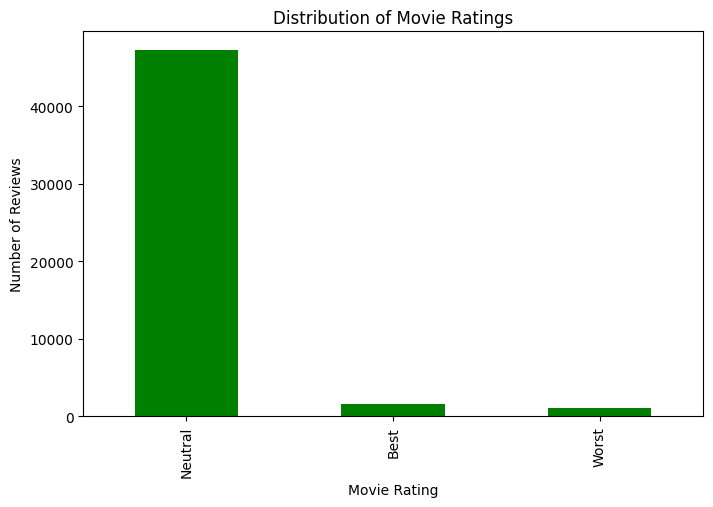

In [ ]:
# Step 1: Calculate Sentiment Scores for Each Genre
genre_sentiment = df.groupby('Genre')['sentiment'].mean()

# Step 2: Determine Best and Worst Genres
best_genre_threshold = genre_sentiment.max() - (genre_sentiment.max() - genre_sentiment.min()) * 0.2
worst_genre_threshold = genre_sentiment.min() + (genre_sentiment.max() - genre_sentiment.min()) * 0.2

best_genres = genre_sentiment[genre_sentiment >= best_genre_threshold].index.tolist()
worst_genres = genre_sentiment[genre_sentiment <= worst_genre_threshold].index.tolist()

# Step 3: Assign Best or Worst Rating
def assign_movie_rating(genre):
    if genre in best_genres:
        return 'Best'
    elif genre in worst_genres:
        return 'Worst'
    else:
        return 'Neutral'

df['Movie_Rating'] = df['Genre'].apply(assign_movie_rating)

# Display the updated dataframe
print(df[['review', 'Genre', 'Movie_Rating']].head())

# Save the updated dataset with ratings
df.to_csv('reviews_with_movie_ratings.csv', index=False)

# Step 4: Visualize the distribution of ratings
import matplotlib.pyplot as plt

rating_counts = df['Movie_Rating'].value_counts()
rating_counts.plot(kind='bar', color='green', figsize=(8, 5))
plt.xlabel('Movie Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Movie Ratings')
plt.show()


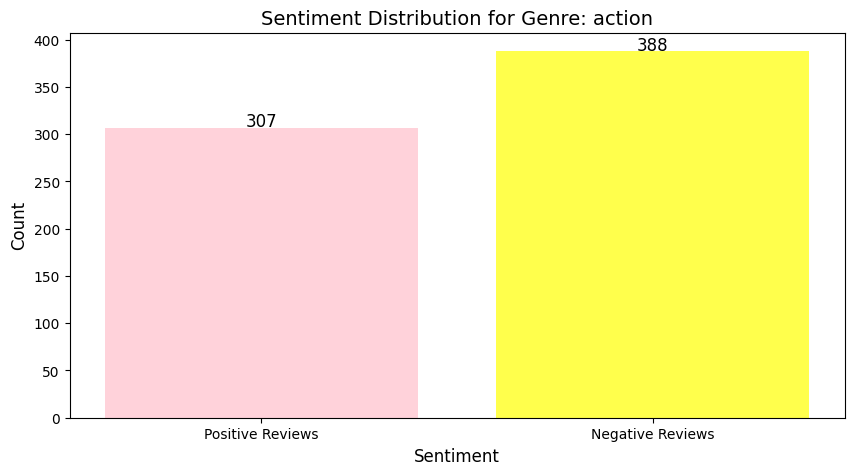

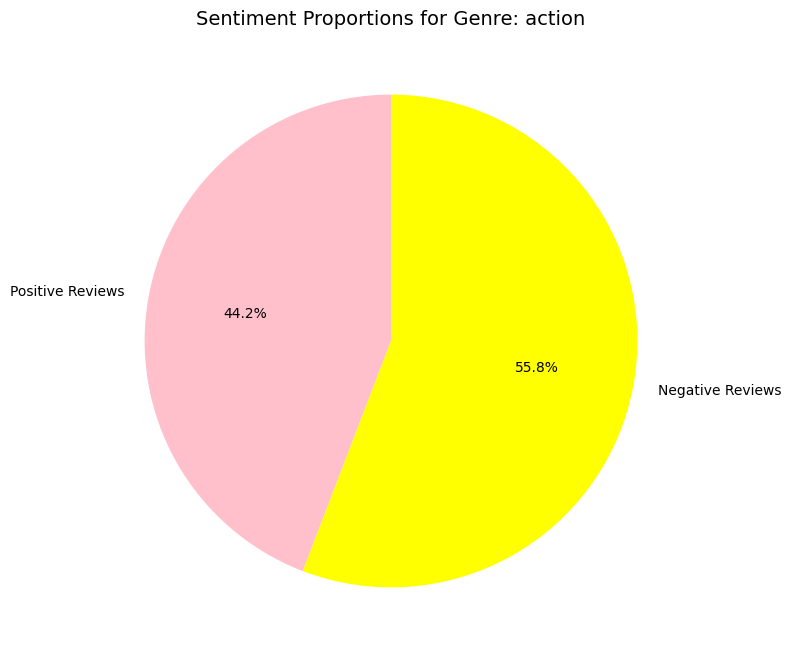

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize positive and negative reviews for a specific genre
def visualize_reviews(genre, df):
    # Filter reviews by the specific genre
    genre_reviews = df[df['Genre'] == genre]

    if genre_reviews.empty:
        print(f"No reviews found for the genre: {genre}")
        return

    # Count positive and negative reviews
    sentiment_counts = genre_reviews['sentiment'].value_counts()
    labels = ['Positive Reviews', 'Negative Reviews']
    counts = [sentiment_counts.get(1, 0), sentiment_counts.get(0, 0)]

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color=['pink', 'yellow'], alpha=0.7)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f"Sentiment Distribution for Genre: {genre}", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', fontsize=12)
    plt.show()

    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['pink', 'yellow'], startangle=90)
    plt.title(f"Sentiment Proportions for Genre: {genre}", fontsize=14)
    plt.show()

# Example Usage
genre = "action"
visualize_reviews(genre, df)